In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Imports

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
from torch.autograd import Variable

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setting the parameters

In [5]:
EXCEL_PATH = '/content/drive/MyDrive/CSE419/Data Mining.xlsx'
EPOCHS = 200
LEARNING_RATE = 0.01
RANDOM_SEED = 42

# Dataset Analysis

In [6]:
df = pd.read_excel(EXCEL_PATH)
df

,DATE,SW273,SW267,SW269
0,1979-06-01,2.60,5.52,5.42
1,1979-06-02,2.43,5.30,5.24
2,1979-06-03,2.40,5.07,5.09
3,1979-06-04,2.29,4.87,4.94
4,1979-06-05,2.20,4.69,4.79
...,...,...,...,...
5010,2009-10-27,3.50,6.13,5.59
5011,2009-10-28,3.34,5.97,5.50
5012,2009-10-29,3.20,5.82,5.42
5013,2009-10-30,3.12,5.70,5.36


In [7]:
# df[['SW267', 'SW269']].iloc[0]

In [8]:
df.describe()

,SW273,SW267,SW269
count,5015.000000,5015.000000,5015.000000
mean,4.971986,8.797886,7.088640
std,1.248850,2.063672,1.233145
min,1.670000,3.140000,3.180000
25%,4.050000,7.730000,6.460000
50%,5.300000,9.510000,7.430000
75%,5.900000,10.340000,7.970000
max,7.780000,12.440000,9.750000


In [9]:
df.SW273.isnull().sum(), df.SW267.isnull().sum(), df.SW269.isnull().sum()

(0, 0, 0)

# GPU or CPU

In [10]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

# Custom Dataset Class

In [11]:
class FloodDataset(Dataset):
  """Custom Dataset class to work with FloodDataset"""
  def __init__(self, excel_path, train, items=None):
    df = pd.read_excel(excel_path)
    
    if items and train==True:
      df = df[:items]

    elif items and train==False:
      df = df[-items:]

    df['index'] = range(0, len(df))
    df = df.set_index('index')
    
    self.excel_path = excel_path
    self.features = df[['SW273','SW269']]
    self.targets = df[['SW267']]

  def __getitem__(self, index):
    return torch.tensor(self.features.iloc[index], dtype=torch.float32), torch.tensor(self.targets.iloc[index], dtype=torch.float32)

  def __len__(self):
    return len(self.features)

# Dataset and Dataloader

In [12]:
train_dataset = FloodDataset(excel_path=EXCEL_PATH,
                             train=True,
                             items = 4011)
test_dataset = FloodDataset(excel_path=EXCEL_PATH,
                             train=False,
                             items = 1003)
print(f'Length Train Dataset: {len(train_dataset)} \nLength of Test Dataset: {len(test_dataset)}')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size = 1000,
                          shuffle=False,
                          num_workers = 0)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size = 1003,
                         shuffle=False,
                         num_workers=0)

print(f'Length Train Loader: {len(train_loader)} \nLength of Test Loader: {len(test_loader)}')

Length Train Dataset: 4011 
Length of Test Dataset: 1003
Length Train Loader: 5 
Length of Test Loader: 1


In [13]:
# train_dataset.input, train_dataset.output
# test_dataset.input, test_dataset.output

In [14]:
# sample = next(iter(train_loader))
# print(len(sample))
# inp, out = sample
# print(inp.shape, out.shape)
# type(inp) ,type(out)

# Building the ANN Model

In [15]:
class ANN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(ANN, self).__init__()
    self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.relu = nn.ReLU()
    self.output_layer = nn.Linear(in_features=hidden_size, out_features=num_classes)

  def forward(self, x):
#     x = x.reshape(x.size(0), 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.output_layer(x)
    return x

# Initializing an ANN object with Optimizer

In [16]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ANN(2,20,1)
model = model.to(DEVICE)

# optimizer = torch.optim.SGD(model.parameters(), momentum = 0.5, lr = LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [17]:
print(model)

ANN(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)


# Evaluation Metrcis

In [18]:
def Loss(preds, targets, train):
    error = preds-targets
    abs_error = torch.abs(error)
    
    mse = torch.sum(error**2)
    rmse = torch.sqrt(mse/len(preds))
    
    if train==True:
        return mse, rmse
    else:
        mae = torch.sum(abs_error)
        mape = torch.sum(abs_error/targets)

        targets_mean = torch.mean(targets)
        preds_mean = torch.mean(preds)
        r_square_numerator = torch.sum((targets-targets_mean)*(preds-preds_mean))**2
        r_square_denominator = torch.sum((targets-targets_mean)**2)*torch.sum((preds-preds_mean)**2)
        r_square = r_square_numerator / r_square_denominator

        esd = torch.sum((abs_error - torch.mean(abs_error))**2)
        return mse, rmse, mae, mape, r_square, esd

# Train the ANN

In [19]:
model.train()
criterion = Loss

for epoch in range(EPOCHS):
  train_examples = 0
  train_loss = 0

  for batch ,(features, targets) in enumerate(train_loader):
    features, targets = features.to(DEVICE), targets.to(DEVICE)
    preds = model(features)
    # print(type(preds), preds.shape)
    mse_loss, rmse_loss = criterion(preds, targets, train=True)
    optimizer.zero_grad()
    rmse_loss.backward()
    optimizer.step()
    
    train_examples += len(features)
    train_loss += mse_loss
  
  train_loss = torch.sqrt(train_loss/train_examples)
  print(f'Epoch = {epoch+1} RMSE Training Loss = {format(train_loss, ".5f")}')

Epoch = 1 RMSE Training Loss = 8.87470
Epoch = 2 RMSE Training Loss = 6.03738
Epoch = 3 RMSE Training Loss = 3.08805
Epoch = 4 RMSE Training Loss = 1.06036
Epoch = 5 RMSE Training Loss = 1.81392
Epoch = 6 RMSE Training Loss = 1.00515
Epoch = 7 RMSE Training Loss = 1.04969
Epoch = 8 RMSE Training Loss = 0.82273
Epoch = 9 RMSE Training Loss = 0.88767
Epoch = 10 RMSE Training Loss = 0.83146
Epoch = 11 RMSE Training Loss = 0.80125
Epoch = 12 RMSE Training Loss = 0.82295
Epoch = 13 RMSE Training Loss = 0.81351
Epoch = 14 RMSE Training Loss = 0.77909
Epoch = 15 RMSE Training Loss = 0.80143
Epoch = 16 RMSE Training Loss = 0.79282
Epoch = 17 RMSE Training Loss = 0.76283
Epoch = 18 RMSE Training Loss = 0.78542
Epoch = 19 RMSE Training Loss = 0.77033
Epoch = 20 RMSE Training Loss = 0.75669
Epoch = 21 RMSE Training Loss = 0.76647
Epoch = 22 RMSE Training Loss = 0.75183
Epoch = 23 RMSE Training Loss = 0.75311
Epoch = 24 RMSE Training Loss = 0.74847
Epoch = 25 RMSE Training Loss = 0.74141
Epoch = 2

# Evaluate the ANN

In [20]:
def calculate_scores(model, data_loader, DEVICE):
  criterion = Loss 
  train_examples = 0
  total_mae = total_mse = total_mape = total_r_square = total_esd = 0.0

  for batch, (features, targets) in enumerate(data_loader):
    features, targets = features.to(DEVICE), targets.to(DEVICE)
    preds = model(features)
    
    mse, rmse, mae, mape, r_square, esd = criterion(preds, targets, train=False)
    total_mae += mae
    total_mse += mse
    total_mape += mape
    train_examples +=len(features)
    total_r_square += r_square
    total_esd += esd

  total_RMSE_loss = format(torch.sqrt((total_mse)/train_examples), '.5f')
  total_mse_loss = format(total_mse/train_examples, '.5f')
  total_mae_loss = format(total_mae/train_examples, '.5f')
  total_mape_loss = format(total_mape/train_examples, '.5f')
  total_r_square = format(total_r_square, '.5f')
  total_esd = format(torch.sqrt(esd/train_examples), '.5f')

  return preds, total_RMSE_loss, total_mse_loss, total_mae_loss, total_mape_loss, total_r_square, total_esd 
  # print(f'total_RMSE_loss: {total_RMSE_loss}\ntotal_mse_loss: {total_mse_loss}\ntotal_mae_loss: {total_mae_loss}\ntotal_mape_loss: {total_mape_loss}\ntotal_r_square:{total_r_square}\ntotal_esd: {total_esd}')

In [21]:
model.eval()

with torch.set_grad_enabled(False):
  preds, total_RMSE_loss, total_mse_loss, total_mae_loss, total_mape_loss, total_r_square, total_esd  = calculate_scores(model, test_loader, DEVICE)
print(f'total_RMSE_loss: {total_RMSE_loss}\ntotal_mse_loss: {total_mse_loss}\ntotal_mae_loss: {total_mae_loss}\ntotal_mape_loss: {total_mape_loss}\ntotal_r_square:{total_r_square}\ntotal_esd: {total_esd}')

total_RMSE_loss: 0.50890
total_mse_loss: 0.25898
total_mae_loss: 0.40569
total_mape_loss: 0.04631
total_r_square:0.93334
total_esd: 0.30724


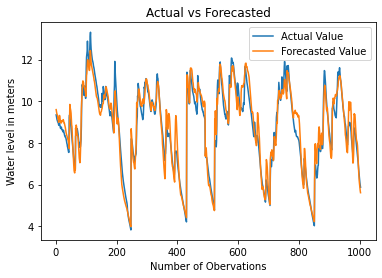

In [29]:
import matplotlib.pyplot as plt

# line 1 points
x1 = [x for x in range(1, 1004)]
y1 = preds
# plotting the line 1 points
plt.plot(x1, y1, label = "Actual Value")

# line 2 points
x2 = [x for x in range(1, 1004)]
y2 = test_dataset.targets
# plotting the line 2 points
plt.plot(x2, y2, label = "Forecasted Value")

# naming the x axis
plt.xlabel('Number of Obervations')
# naming the y axis
plt.ylabel('Water level in meters')
# giving a title to my graph
plt.title('Actual vs Forecasted')

# show a legend on the plot
plt.legend()

plt.savefig('/content/drive/MyDrive/CSE419/ANN_Actual_vs_Forecasted.jpg', dpi=400)

# function to show the plot
plt.show()

